In [1]:
#Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d, CubicSpline
from tqdm import tqdm
import time
from glob import glob


%matplotlib inline

In [2]:
rv_tmplt_directory = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets\\RVgrid"
conv_tmplt_list = glob(os.path.join(rv_tmplt_directory,"*.conv"))
len(conv_tmplt_list)

730

In [3]:
tmplt_specs = []
tmplt_wavelengths = []
tmplt_norm_og = []
#3470,5540
observed_wavelengths = np.linspace(3470,5540,1036)
for i in range(len(conv_tmplt_list)):
    current = np.loadtxt(conv_tmplt_list[i])
    tmplt_specs.append(current[:,2])
    tmplt_wavelengths.append(current[:,0])
    tmplt_norm_og.append(current[:,1])
    

In [4]:
observed_wavelengths = np.linspace(3470,5540,1036)

refit_tmplt_spec_arr = []

for i in range(len(tmplt_specs)):
    cs = CubicSpline(tmplt_wavelengths[i],tmplt_specs[i])
    refit_tmplt_spec = np.array(cs(observed_wavelengths))
    refit_tmplt_spec_arr.append(refit_tmplt_spec)

In [5]:
uncut_spec = []
for i in range(len(refit_tmplt_spec_arr)):
    uncut_spec.append(refit_tmplt_spec_arr[i])
    refit_tmplt_spec_arr[i] = refit_tmplt_spec_arr[i][50:-50]
uncut_spec = np.array(uncut_spec)

In [6]:
"""
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,uncut_spec_data,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    percentile_idx = int(percentile * window_size) #Since the 
    first_reflection = uncut_spec_data[:half_window_size]
    second_reflection = uncut_spec_data[-half_window_size:]
    extended_flux = np.concatenate([first_reflection,resampled_flux,second_reflection])

    running_stack = sorted(extended_flux[:window_size]) #Stars as a sorted list of the first 100 
    continuum = [] #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len + half_window_size):
        #remove operation
        removal_val = extended_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = extended_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

counter = 0
for resampled_flux in tqdm(refit_tmplt_spec_arr):
    uncut_spec_data = uncut_spec[counter]
    BMC(resampled_flux,uncut_spec_data,100,0.98,BMC_timings,normalized_spectra,continuums)
    counter += 1
"""

"\n#Implementing Boosted Median Continuum On Spectra\nBMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)\nnormalized_spectra = [] #Stores the normalized spectra\ncontinuums = [] #Stores the continuums of the spectra\n\ndef BMC(resampled_flux,uncut_spec_data,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):\n\n    start = time.perf_counter()\n\n    spec_len = len(resampled_flux) \n    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window\n    percentile_idx = int(percentile * window_size) #Since the \n    first_reflection = uncut_spec_data[:half_window_size]\n    second_reflection = uncut_spec_data[-half_window_size:]\n    extended_flux = np.concatenate([first_reflection,resampled_flux,second_reflection])\n\n    running_stack = sorted(extended_flux[:window_size]) #Stars 

In [7]:
"""
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    running_stack = sorted(resampled_flux[:window_size]) #Stars as a sorted list of the first 100 
    percentile_idx = int(percentile * window_size) #Since the 
    continuum = [running_stack[percentile_idx]] * half_window_size #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len-half_window_size):

        #remove operation
        removal_val = resampled_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = resampled_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum += [continuum[-1]] * 50  #Window remains stationary for the last half_window_size values so we append the same value
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(refit_tmplt_spec_arr):
    BMC(resampled_flux,100,0.98,BMC_timings,normalized_spectra,continuums)
"""

"\n#Implementing Boosted Median Continuum On Spectra\nBMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)\nnormalized_spectra = [] #Stores the normalized spectra\ncontinuums = [] #Stores the continuums of the spectra\n\ndef BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):\n\n    start = time.perf_counter()\n\n    spec_len = len(resampled_flux) \n    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window\n    running_stack = sorted(resampled_flux[:window_size]) #Stars as a sorted list of the first 100 \n    percentile_idx = int(percentile * window_size) #Since the \n    continuum = [running_stack[percentile_idx]] * half_window_size #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_f

In [8]:

#New BMC
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=98,normalized_spectra=[],continuums=[]):

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    
    continuum = []
    
    for i in range(half_window_size, spec_len-half_window_size):
        continuum_val = np.percentile(resampled_flux[i-half_window_size:i+half_window_size+1],percentile)
        continuum.append(continuum_val)

    continuum = ([continuum[0]] * half_window_size) + continuum
    continuum += [continuum[-1]] * half_window_size  #Window remains stationary for the last half_window_size values so we append the same value
    
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(refit_tmplt_spec_arr):
    BMC(resampled_flux,50,97,normalized_spectra,continuums)

100%|██████████| 730/730 [02:19<00:00,  5.22it/s]


In [9]:
"""
lambs = np.linspace(3570,5440,936)
from scipy import stats

normalized_spectra = [] #Stores the normalized spectra

def BMCcntflux(lams, fluxes,width = 100,ptile=98):
	continuumflux = []

	for i in np.arange(len(fluxes)):
		testind = np.where((lams >= lams[i]-(width/2.0)) & (lams <= lams[i]+(width/2.0)))[0]
		continuumflux.append(stats.scoreatpercentile(fluxes[testind],ptile))
	norm_spec = fluxes/continuumflux
	return norm_spec

for resampled_flux in tqdm(refit_tmplt_spec_arr):
    normalized_spectra.append(BMCcntflux(lambs,resampled_flux,100,98))
	"""

'\nlambs = np.linspace(3570,5440,936)\nfrom scipy import stats\n\nnormalized_spectra = [] #Stores the normalized spectra\n\ndef BMCcntflux(lams, fluxes,width = 100,ptile=98):\n\tcontinuumflux = []\n\n\tfor i in np.arange(len(fluxes)):\n\t\ttestind = np.where((lams >= lams[i]-(width/2.0)) & (lams <= lams[i]+(width/2.0)))[0]\n\t\tcontinuumflux.append(stats.scoreatpercentile(fluxes[testind],ptile))\n\tnorm_spec = fluxes/continuumflux\n\treturn norm_spec\n\nfor resampled_flux in tqdm(refit_tmplt_spec_arr):\n    normalized_spectra.append(BMCcntflux(lambs,resampled_flux,100,98))\n\t'

In [10]:
"""
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=0.98,normalized_spectra=[],continuums=[]):


    spec_len = len(resampled_flux) 
    continuum = []
    start_idx = 0
    while start_idx < spec_len:
        new_stack = resampled_flux[start_idx:start_idx+window_size]
        continuum += [sorted(new_stack)[int(percentile*len(new_stack))]] * window_size
        start_idx += window_size

    continuum = np.array(continuum[:spec_len])
    normalized = resampled_flux/continuum
    
    normalized_spectra.append(normalized)
    continuums.append(continuum)


counter = 0
for resampled_flux in tqdm(refit_tmplt_spec_arr):
    BMC(resampled_flux,100,0.98,normalized_spectra,continuums)
    counter += 1
"""

'\nnormalized_spectra = [] #Stores the normalized spectra\ncontinuums = [] #Stores the continuums of the spectra\n\ndef BMC(resampled_flux,window_size=50,percentile=0.98,normalized_spectra=[],continuums=[]):\n\n\n    spec_len = len(resampled_flux) \n    continuum = []\n    start_idx = 0\n    while start_idx < spec_len:\n        new_stack = resampled_flux[start_idx:start_idx+window_size]\n        continuum += [sorted(new_stack)[int(percentile*len(new_stack))]] * window_size\n        start_idx += window_size\n\n    continuum = np.array(continuum[:spec_len])\n    normalized = resampled_flux/continuum\n    \n    normalized_spectra.append(normalized)\n    continuums.append(continuum)\n\n\ncounter = 0\nfor resampled_flux in tqdm(refit_tmplt_spec_arr):\n    BMC(resampled_flux,100,0.98,normalized_spectra,continuums)\n    counter += 1\n'

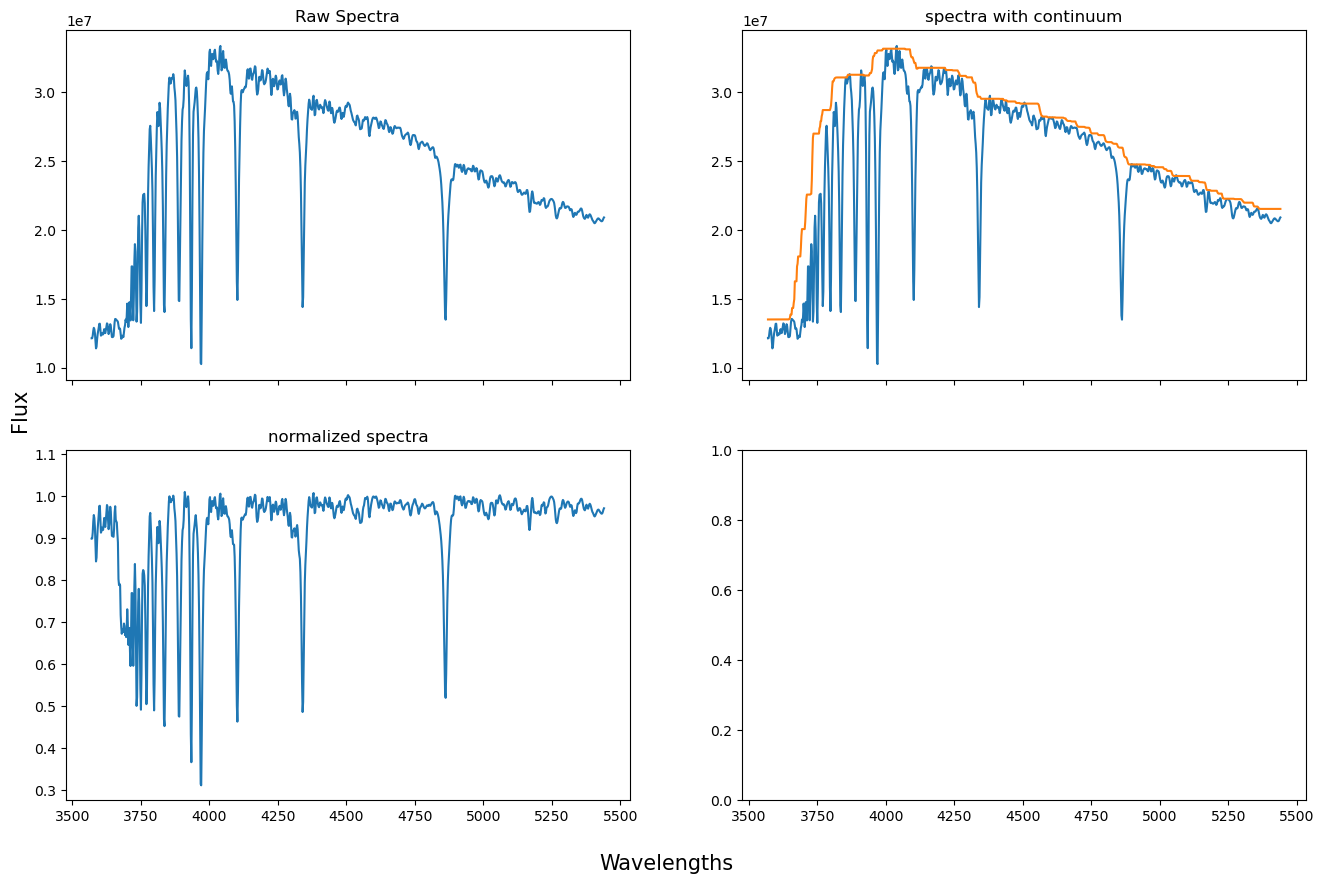

In [11]:
#Plotting graphs
idx = 700 #change this to the idx of the spectra you want to see
continuum = continuums[idx]
normalized = normalized_spectra[idx]
resampled_flux = refit_tmplt_spec_arr[idx]

observed_wavelengths = np.linspace(3470,5540,1036)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)

observed_wavelengths = np.linspace(3570,5440,len(continuum))

ax1.plot(observed_wavelengths,resampled_flux)
ax1.set_title("Raw Spectra")


ax2.plot(observed_wavelengths,resampled_flux)
ax2.plot(observed_wavelengths,continuum)

ax2.set_title("spectra with continuum")

ax3.plot(observed_wavelengths,normalized)
ax3.set_ylim(top=max(normalized)+0.1)
ax3.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()

ax4.plot(tmplt_wavelengths[idx],tmplt_norm_og[idx])
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()

In [12]:
t = Table([tmplt_specs,tmplt_wavelengths,continuums,normalized_spectra,tmplt_norm_og,refit_tmplt_spec_arr],names=("specs","wavelengths","continuums","norm_specs","og_norm","refit_tmplt"))

In [13]:

#t = Table([tmplt_specs,tmplt_wavelengths,normalized_spectra,tmplt_norm_og,refit_tmplt_spec_arr],names=("specs","wavelengths","norm_specs","og_norm","refit_tmplt"))

In [14]:
from astropy.io import fits
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
modified_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
hdu = fits.BinTableHDU(t)
hdu.writeto(modified_data_path,overwrite=True)

In [15]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)

continuums
norm_specs
og_norm
refit_tmplt
specs
wavelengths
